# Kapitel 1 - Einfach Regression

____

## Daten Simulation

### Aufbau:

Datensimulierendes Modell:
$$ y = \beta_0 + \beta_1 x_i + \epsilon$$
wobei $\epsilon \sim N(0, 1)$. $beta_0 = 1$, $beta_1 = 3$, die X-Werte werden aus einer Gleichverteilung gezogen mit $X \sim U(1, 5)$

Grundmodell ist gegeben als:
$$ \hat{y} = \beta_0 + \beta_1 x_i $$


### Libraries

In [1]:
# System libraries
import random
import copy
# Custom libraries
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt
# visualisierung
import tensorboard
tensorboard.__version__

'2.8.0'

### Random Seeds

In [2]:
random.seed(42)
tf.random.set_seed(42)

n = Anzahl an Beobachtungen (100)

k = Anzahl Koeff ohne Intercept

In [3]:
n = 100
X = np.random.normal(loc=0.0, scale=1.0, size =n)
X = X.reshape(n, 1)
koef = np.array((3))
koef = koef.reshape(1,1)
noise = np.random.normal(loc=0.0, scale=1.0, size=n)
noise = noise.reshape(n, 1)
y = 1 + np.matmul(X, koef) + noise
y = pd.DataFrame(y)
X = pd.DataFrame(X)

____

## No Hidden Layers/Units

### Optimizer

(Stochastic) Gradient Descent, Learning Rate 0.01, kein momentum, kein Nestov.

In [4]:
opt = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.0, nesterov=False, name='SGD')

### Grundlegendes Model

In [5]:
random.seed(42)
tf.random.set_seed(42)

In [6]:
model0 = tf.keras.Sequential()
model0.add(tf.keras.layers.Dense(1,  activation='linear', batch_input_shape=(None, 1)))
model0.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=opt)
model0.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 2         
                                                                 
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


### Fitten

Batch_size = n, da wir quasi "normalen" Gradient Descent haben wollen. 

In [7]:
hist = model0.fit(X, y, epochs = 300, batch_size=100, use_multiprocessing=True, verbose=0)

### Trainingsprozess plotten

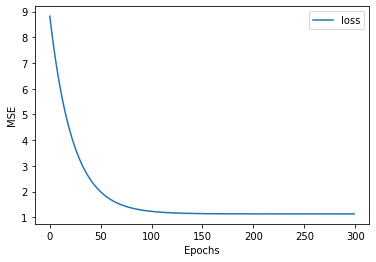

In [8]:
plt.plot(hist.history['loss'])
plt.legend(['loss'])
plt.ylabel('MSE')
plt.xlabel('Epochs')
plt.show()

### Ergebnisse

- $\hat{y}$ auslesen/berechnen.
- Ausgeben der "letzten" Loss.

In [9]:
yhat = model0.predict(X)
model0.get_weights()
print("Loss der letzten Epoche:", hist.history['loss'][n - 1], "\nweights:", model0.get_weights())

Loss der letzten Epoche: 1.2369025945663452 
weights: [array([[2.965747]], dtype=float32), array([1.1505269], dtype=float32)]


____

### No Hidden Units

- Difference h : 1e-5

In [10]:
h = 1e-5

### Forward Differences

In [11]:
gewichte_m1 = [ ]
y_iter = []
gewichte_m2 = [ ]
fits = []

100 Modelle fitten

In [12]:
%%capture
for i in range(len(X)):
  temp_y = copy.deepcopy(y)
  temp_y.loc[i] += h
  y_iter.append(temp_y)
  np.sum(temp_y - y)
  random.seed(42)
  tf.random.set_seed(42)
  model2 = tf.keras.Sequential();
  model2.add(tf.keras.layers.Dense(1,  activation='linear', batch_input_shape=(None, 1)));
  model2.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=opt);
  hist = model2.fit(X, temp_y, epochs = 300, batch_size=100, use_multiprocessing=True, verbose=0);
  coefs_m2 = np.vstack((model2.get_weights()[0]))
  gewichte_m2.append( coefs_m2 )
  temp_pred = model2.predict(X)
  fits.append(temp_pred[i]);

In [13]:
fits_f = copy.deepcopy(np.array(fits))

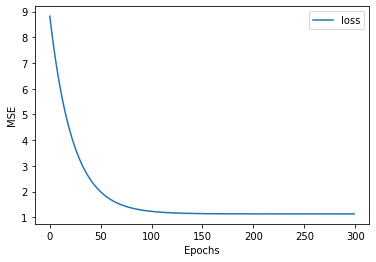

In [14]:
plt.plot(hist.history['loss'])
plt.legend(['loss'])
plt.ylabel('MSE')
plt.xlabel('Epochs')
plt.show()

### Backwards Differences

In [15]:
gewichte_m1 = [ ]
y_iter = []
gewichte_m2 = [ ]
fits = []

In [16]:
%%capture
for i in range(len(X)):
  temp_y = copy.deepcopy(y)
  temp_y.loc[i] -= h
  y_iter.append(temp_y)
  np.sum(temp_y - y)
  random.seed(42)
  tf.random.set_seed(42)
  model2 = tf.keras.Sequential();
  model2.add(tf.keras.layers.Dense(1,  activation='linear', batch_input_shape=(None, 1)));
  model2.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=opt);
  hist = model2.fit(X, temp_y, epochs = 300, batch_size=100, use_multiprocessing=True, verbose=0);
  coefs_m2 = np.vstack((model2.get_weights()[0]))
  gewichte_m2.append( coefs_m2 )
  temp_pred = model2.predict(X)
  fits.append(temp_pred[i]);

In [17]:
fits_b = copy.deepcopy( np.array(fits))  # sicherheitshalber richtiges format.

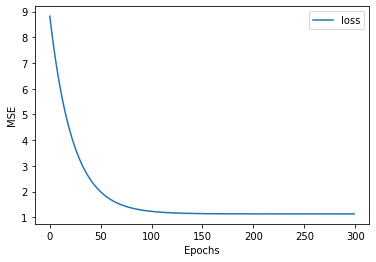

In [18]:
plt.plot(hist.history['loss'])
plt.legend(['loss'])
plt.ylabel('MSE')
plt.xlabel('Epochs')
plt.show()

### Analyse

#### Forward Differences

In [19]:
np.sum((fits_f - yhat) / h)

0.9775162

#### Backward Differences

In [20]:
np.sum((yhat - fits_b) / h)

2.3961067

#### Centred Differences

In [21]:
np.sum((fits_f - fits_b) / (2 * h))

1.6868114

#### Anzahl der trainable Parameter im Model

In [22]:
model0.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 2         
                                                                 
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


____

## 1-Hidden Layer

### 1-Hidden Units

In [23]:
random.seed(42)
tf.random.set_seed(42)

In [24]:
model0 = tf.keras.Sequential()
model0.add(tf.keras.layers.Dense(1,  activation='linear', batch_input_shape=(None, 1)))
model0.add(tf.keras.layers.Dense(1,  activation='linear'))
model0.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=opt)
model0.summary()

Model: "sequential_201"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_201 (Dense)           (None, 1)                 2         
                                                                 
 dense_202 (Dense)           (None, 1)                 2         
                                                                 
Total params: 4
Trainable params: 4
Non-trainable params: 0
_________________________________________________________________


In [25]:
hist = model0.fit(X, y, epochs = 300, batch_size=100, use_multiprocessing=True, verbose=0)

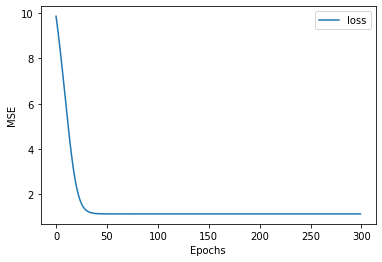

In [26]:
plt.plot(hist.history['loss'])
plt.legend(['loss'])
plt.ylabel('MSE')
plt.xlabel('Epochs')
plt.show()

In [27]:
yhat = model0.predict(X)
model0.get_weights()
print("Loss der letzten Epoche:", hist.history['loss'][n - 1])

Loss der letzten Epoche: 1.1345096826553345


#### Forward Differences

In [28]:
gewichte_m1 = [ ]
y_iter = []
gewichte_m2 = [ ]
fits = []

In [29]:
%%capture
for i in range(len(X)):
  temp_y = copy.deepcopy(y)
  temp_y.loc[i] += h
  y_iter.append(temp_y)
  np.sum(temp_y - y)
  random.seed(42)
  tf.random.set_seed(42)
  model2 = tf.keras.Sequential()
  model2.add(tf.keras.layers.Dense(1,  activation='linear', batch_input_shape=(None, 1)))
  model2.add(tf.keras.layers.Dense(1,  activation='linear'))
  model2.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=opt)
  hist = model2.fit(X, temp_y, epochs = 300, batch_size=100, use_multiprocessing=True, verbose=0);
  coefs_m2 = np.vstack((model2.get_weights()[0]))
  gewichte_m2.append( coefs_m2 )
  temp_pred = model2.predict(X)
  fits.append(temp_pred[i]);

In [30]:
fits_f = copy.deepcopy(np.array(fits))

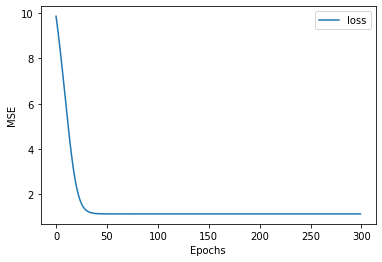

In [31]:
plt.plot(hist.history['loss'])
plt.legend(['loss'])
plt.ylabel('MSE')
plt.xlabel('Epochs')
plt.show()

In [32]:
print("Loss der letzten Epoche:", hist.history['loss'][n - 1])

Loss der letzten Epoche: 1.1345096826553345


#### Backward Differences

In [33]:
gewichte_m1 = [ ]
y_iter = []
gewichte_m2 = [ ]
fits = []

In [34]:
%%capture
for i in range(len(X)):
  temp_y = copy.deepcopy(y)
  temp_y.loc[i] -= h
  y_iter.append(temp_y)
  np.sum(temp_y - y)
  random.seed(42)
  tf.random.set_seed(42)
  model2 = tf.keras.Sequential()
  model2.add(tf.keras.layers.Dense(1,  activation='linear', batch_input_shape=(None, 1)))
  model2.add(tf.keras.layers.Dense(1,  activation='linear'))
  model2.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=opt)
  hist = model2.fit(X, temp_y, epochs = 300, batch_size=100, use_multiprocessing=True, verbose=0);
  coefs_m2 = np.vstack((model2.get_weights()[0]))
  gewichte_m2.append( coefs_m2 )
  temp_pred = model2.predict(X)
  fits.append(temp_pred[i]);

In [35]:
fits_b = copy.deepcopy(np.array(fits))

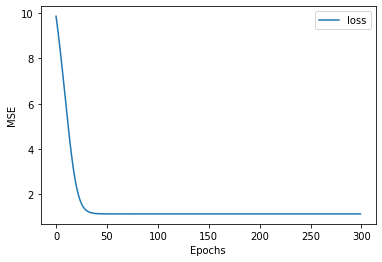

In [36]:
plt.plot(hist.history['loss'])
plt.legend(['loss'])
plt.ylabel('MSE')
plt.xlabel('Epochs')
plt.show()

In [37]:
print("Loss der letzten Epoche:", hist.history['loss'][n - 1])

Loss der letzten Epoche: 1.134509801864624


#### Analyse

#### Forward Differences

In [38]:
np.sum((fits_f - yhat) / h)

1.8686056

#### Backward Differences

In [39]:
np.sum((yhat - fits_b) / h)

1.9133091

#### Centred Differences

In [40]:
np.sum((fits_f - fits_b) / (2 * h))

1.8909574

#### Anazhl trainable Parameters

In [41]:
model0.summary()

Model: "sequential_201"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_201 (Dense)           (None, 1)                 2         
                                                                 
 dense_202 (Dense)           (None, 1)                 2         
                                                                 
Total params: 4
Trainable params: 4
Non-trainable params: 0
_________________________________________________________________


____

### 5-Hidden Units (macht keinen Sinn, zum Spaß drin)

Die Anzahl im vorletzten Layer an Units definiert das Modell.

In [42]:
random.seed(42)
tf.random.set_seed(42)

In [43]:
model0 = tf.keras.Sequential()
model0.add(tf.keras.layers.Dense(5,  activation='linear', batch_input_shape=(None, 1)))
model0.add(tf.keras.layers.Dense(1,  activation='linear'))
model0.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=opt)
model0.summary()
hist = model0.fit(X, y, epochs = 300, batch_size=100, use_multiprocessing=True, verbose=0)

Model: "sequential_402"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_603 (Dense)           (None, 5)                 10        
                                                                 
 dense_604 (Dense)           (None, 1)                 6         
                                                                 
Total params: 16
Trainable params: 16
Non-trainable params: 0
_________________________________________________________________


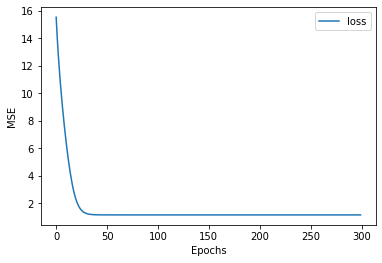

In [44]:
plt.plot(hist.history['loss'])
plt.legend(['loss'])
plt.ylabel('MSE')
plt.xlabel('Epochs')
plt.show()

In [45]:
yhat = model0.predict(X)
model0.get_weights()
print("Loss der letzten Epoche:", hist.history['loss'][n - 1])

Loss der letzten Epoche: 1.1345093250274658


#### Forward Differences

In [46]:
gewichte_m1 = [ ]
y_iter = []
gewichte_m2 = [ ]
fits = []

In [47]:
%%capture
for i in range(len(X)):
  temp_y = copy.deepcopy(y)
  temp_y.loc[i] += h
  y_iter.append(temp_y)
  np.sum(temp_y - y)
  random.seed(42)
  tf.random.set_seed(42)
  model2 = tf.keras.Sequential()
  model2.add(tf.keras.layers.Dense(5,  activation='linear', batch_input_shape=(None, 1)))
  model2.add(tf.keras.layers.Dense(1,  activation='linear'))
  model2.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=opt)
  hist = model2.fit(X, temp_y, epochs = 300, batch_size=100, use_multiprocessing=True, verbose=0);
  coefs_m2 = np.vstack((model2.get_weights()[0]))
  gewichte_m2.append( coefs_m2 )
  temp_pred = model2.predict(X)
  fits.append(temp_pred[i]);
fits_f = copy.deepcopy(np.array(fits))

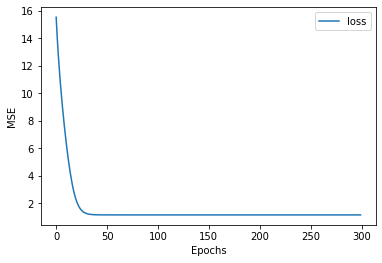

In [48]:
plt.plot(hist.history['loss'])
plt.legend(['loss'])
plt.ylabel('MSE')
plt.xlabel('Epochs')
plt.show()

In [49]:
print("Loss der letzten Epoche:", hist.history['loss'][n - 1])

Loss der letzten Epoche: 1.1345090866088867


#### Backward Differences

In [50]:
gewichte_m1 = [ ]
y_iter = []
gewichte_m2 = [ ]
fits = []

In [51]:
%%capture
for i in range(len(X)):
  temp_y = copy.deepcopy(y)
  temp_y.loc[i] -= h
  y_iter.append(temp_y)
  np.sum(temp_y - y)
  random.seed(42)
  tf.random.set_seed(42)
  model2 = tf.keras.Sequential()
  model2.add(tf.keras.layers.Dense(5,  activation='linear', batch_input_shape=(None, 1)))
  model2.add(tf.keras.layers.Dense(1,  activation='linear'))
  model2.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=opt)
  hist = model2.fit(X, temp_y, epochs = 300, batch_size=100, use_multiprocessing=True, verbose=0);
  coefs_m2 = np.vstack((model2.get_weights()[0]))
  gewichte_m2.append( coefs_m2 )
  temp_pred = model2.predict(X)
  fits.append(temp_pred[i]);
fits_b = copy.deepcopy(np.array(fits))


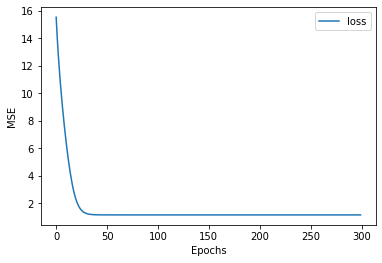

In [52]:
plt.plot(hist.history['loss'])
plt.legend(['loss'])
plt.ylabel('MSE')
plt.xlabel('Epochs')
plt.show()

In [53]:
print("Loss der letzten Epoche:", hist.history['loss'][n - 1])

Loss der letzten Epoche: 1.1345093250274658


#### Analyse

##### Forward Differences

In [54]:
np.sum((fits_f - yhat) / h)

1.9311905

##### Backward Differences

In [55]:
np.sum((yhat - fits_b) / h)

1.8149614

##### Centred Differences

In [56]:
np.sum((fits_f - fits_b) / (2 * h))

1.873076

#### Anzahl trainable Parameters

In [57]:
model0.summary()

Model: "sequential_402"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_603 (Dense)           (None, 5)                 10        
                                                                 
 dense_604 (Dense)           (None, 1)                 6         
                                                                 
Total params: 16
Trainable params: 16
Non-trainable params: 0
_________________________________________________________________


____


## Zwei Hidden Layer 

### 1-Hidden Unit

In [58]:
random.seed(42)
tf.random.set_seed(42)
model0 = tf.keras.Sequential()
model0.add(tf.keras.layers.Dense(1,  activation='linear', batch_input_shape=(None, 1)))
model0.add(tf.keras.layers.Dense(1,  activation='linear'))
model0.add(tf.keras.layers.Dense(1,  activation='linear'))
model0.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=opt)
model0.summary()
hist = model0.fit(X, y, epochs = 300, batch_size=100, use_multiprocessing=True, verbose=0)

Model: "sequential_603"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1005 (Dense)          (None, 1)                 2         
                                                                 
 dense_1006 (Dense)          (None, 1)                 2         
                                                                 
 dense_1007 (Dense)          (None, 1)                 2         
                                                                 
Total params: 6
Trainable params: 6
Non-trainable params: 0
_________________________________________________________________


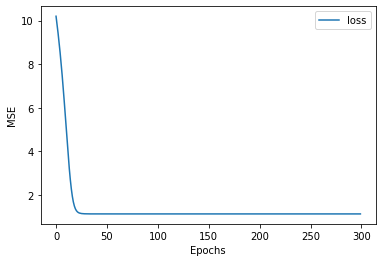

In [59]:
plt.plot(hist.history['loss'])
plt.legend(['loss'])
plt.ylabel('MSE')
plt.xlabel('Epochs')
plt.show()

In [60]:
yhat = model0.predict(X)
model0.get_weights()
print("Loss der letzten Epoche:", hist.history['loss'][n - 1])

Loss der letzten Epoche: 1.1345090866088867


#### Forward Differences

In [61]:
gewichte_m1 = [ ]
y_iter = []
gewichte_m2 = [ ]
fits = []
for i in range(len(X)):
  temp_y = copy.deepcopy(y)
  temp_y.loc[i] += h
  y_iter.append(temp_y)
  np.sum(temp_y - y)
  random.seed(42)
  tf.random.set_seed(42)
  model2 = tf.keras.Sequential()
  model2.add(tf.keras.layers.Dense(1,  activation='linear', batch_input_shape=(None, 1)))
  model2.add(tf.keras.layers.Dense(1,  activation='linear'))
  model2.add(tf.keras.layers.Dense(1,  activation='linear'))
  model2.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=opt)
  hist = model2.fit(X, temp_y, epochs = 300, batch_size=100, use_multiprocessing=True, verbose=0);
  coefs_m2 = np.vstack((model2.get_weights()[0]))
  gewichte_m2.append( coefs_m2 )
  temp_pred = model2.predict(X)
  fits.append(temp_pred[i]);
fits_f = copy.deepcopy(np.array(fits))

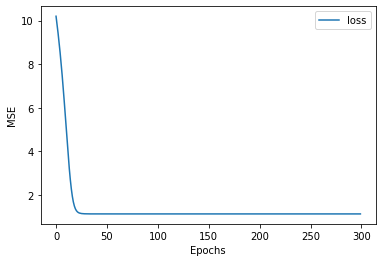

In [62]:
plt.plot(hist.history['loss'])
plt.legend(['loss'])
plt.ylabel('MSE')
plt.xlabel('Epochs')
plt.show()

In [63]:
print("Loss der letzten Epoche:", hist.history['loss'][n - 1])

Loss der letzten Epoche: 1.1345090866088867


#### Backward Differences

In [64]:
gewichte_m1 = [ ]
y_iter = []
gewichte_m2 = [ ]
fits = []
for i in range(len(X)):
  temp_y = copy.deepcopy(y)
  temp_y.loc[i] -= h
  y_iter.append(temp_y)
  np.sum(temp_y - y)
  random.seed(42)
  tf.random.set_seed(42)
  model2 = tf.keras.Sequential()
  model2.add(tf.keras.layers.Dense(1,  activation='linear', batch_input_shape=(None, 1)))
  model2.add(tf.keras.layers.Dense(1,  activation='linear'))
  model2.add(tf.keras.layers.Dense(1,  activation='linear'))
  model2.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=opt)
  hist = model2.fit(X, temp_y, epochs = 300, batch_size=100, use_multiprocessing=True, verbose=0);
  coefs_m2 = np.vstack((model2.get_weights()[0]))
  gewichte_m2.append( coefs_m2 )
  temp_pred = model2.predict(X)
  fits.append(temp_pred[i]);
fits_b = copy.deepcopy(np.array(fits))

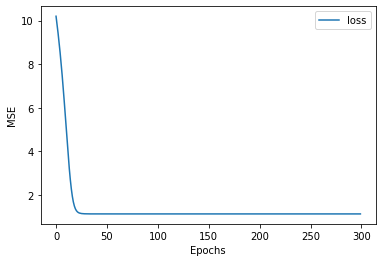

In [65]:
plt.plot(hist.history['loss'])
plt.legend(['loss'])
plt.ylabel('MSE')
plt.xlabel('Epochs')
plt.show()

In [66]:
print("Loss der letzten Epoche:", hist.history['loss'][n - 1])

Loss der letzten Epoche: 1.1345090866088867


#### Analyse

In [67]:
# Forward
np.sum((fits_f - yhat) / h)

2.3022294

In [68]:
##### Backward Differences
np.sum((yhat - fits_b) / h)

1.7315149

In [69]:
##### Centred Differences
np.sum((fits_f - fits_b) / (2 * h))

2.0168722

In [70]:
#### Anzahl trainable Parameters
model0.summary()

Model: "sequential_603"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1005 (Dense)          (None, 1)                 2         
                                                                 
 dense_1006 (Dense)          (None, 1)                 2         
                                                                 
 dense_1007 (Dense)          (None, 1)                 2         
                                                                 
Total params: 6
Trainable params: 6
Non-trainable params: 0
_________________________________________________________________


____

### 5 Hidden Units

In [71]:
random.seed(42)
tf.random.set_seed(42)
model0 = tf.keras.Sequential()
model0.add(tf.keras.layers.Dense(1,  activation='linear', batch_input_shape=(None, 1)))
model0.add(tf.keras.layers.Dense(5,  activation='linear'))
model0.add(tf.keras.layers.Dense(1,  activation='linear'))
model0.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=opt)
model0.summary()
hist = model0.fit(X, y, epochs = 300, batch_size=100, use_multiprocessing=True, verbose=0)

Model: "sequential_804"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1608 (Dense)          (None, 1)                 2         
                                                                 
 dense_1609 (Dense)          (None, 5)                 10        
                                                                 
 dense_1610 (Dense)          (None, 1)                 6         
                                                                 
Total params: 18
Trainable params: 18
Non-trainable params: 0
_________________________________________________________________


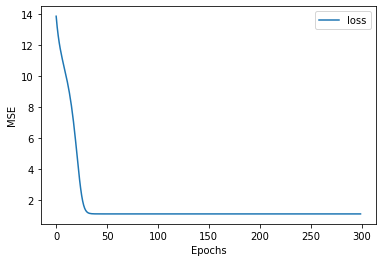

In [72]:
plt.plot(hist.history['loss'])
plt.legend(['loss'])
plt.ylabel('MSE')
plt.xlabel('Epochs')
plt.show()

In [73]:
yhat = model0.predict(X)
model0.get_weights()
print("Loss der letzten Epoche:", hist.history['loss'][n - 1])

Loss der letzten Epoche: 1.1345090866088867


#### Forward Differences

In [74]:
gewichte_m1 = [ ]
y_iter = []
gewichte_m2 = [ ]
fits = []
for i in range(len(X)):
  temp_y = copy.deepcopy(y)
  temp_y.loc[i] += h
  y_iter.append(temp_y)
  np.sum(temp_y - y)
  random.seed(42)
  tf.random.set_seed(42)
  model2 = tf.keras.Sequential()
  model2.add(tf.keras.layers.Dense(1,  activation='linear', batch_input_shape=(None, 1)))
  model2.add(tf.keras.layers.Dense(5,  activation='linear'))
  model2.add(tf.keras.layers.Dense(1,  activation='linear'))
  model2.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=opt)
  hist = model2.fit(X, temp_y, epochs = 300, batch_size=100, use_multiprocessing=True, verbose=0);
  coefs_m2 = np.vstack((model2.get_weights()[0]))
  gewichte_m2.append( coefs_m2 )
  temp_pred = model2.predict(X)
  fits.append(temp_pred[i]);
fits_f = copy.deepcopy(np.array(fits))

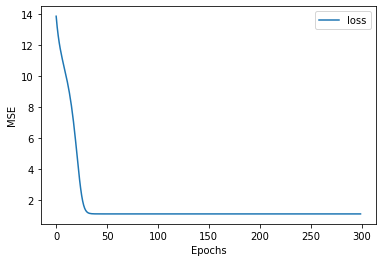

In [75]:
plt.plot(hist.history['loss'])
plt.legend(['loss'])
plt.ylabel('MSE')
plt.xlabel('Epochs')
plt.show()

In [76]:
yhat = model0.predict(X)
model0.get_weights()
print("Loss der letzten Epoche:", hist.history['loss'][n - 1])

Loss der letzten Epoche: 1.1345092058181763


#### Backward Differences

In [77]:
gewichte_m1 = [ ]
y_iter = []
gewichte_m2 = [ ]
fits = []
for i in range(len(X)):
  temp_y = copy.deepcopy(y)
  temp_y.loc[i] -= h
  y_iter.append(temp_y)
  np.sum(temp_y - y)
  random.seed(42)
  tf.random.set_seed(42)
  model2 = tf.keras.Sequential()
  model2.add(tf.keras.layers.Dense(1,  activation='linear', batch_input_shape=(None, 1)))
  model2.add(tf.keras.layers.Dense(5,  activation='linear'))
  model2.add(tf.keras.layers.Dense(1,  activation='linear'))
  model2.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=opt)
  hist = model2.fit(X, temp_y, epochs = 300, batch_size=100, use_multiprocessing=True, verbose=0);
  coefs_m2 = np.vstack((model2.get_weights()[0]))
  gewichte_m2.append( coefs_m2 )
  temp_pred = model2.predict(X)
  fits.append(temp_pred[i]);
fits_b = copy.deepcopy(np.array(fits))

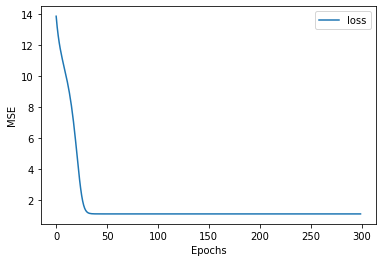

In [78]:
plt.plot(hist.history['loss'])
plt.legend(['loss'])
plt.ylabel('MSE')
plt.xlabel('Epochs')
plt.show()

In [79]:
print("Loss der letzten Epoche:", hist.history['loss'][n - 1])

Loss der letzten Epoche: 1.1345093250274658


#### Analyse

In [80]:
# Forward
np.sum((fits_f - yhat) / h)


1.9878149

In [81]:
##### Backward Differences
np.sum((yhat - fits_b) / h)


1.8626451

In [82]:
##### Centred Differences
np.sum((fits_f - fits_b) / (2 * h))


1.92523

In [83]:
#### Anzahl trainable Parameters
model0.summary()

Model: "sequential_804"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1608 (Dense)          (None, 1)                 2         
                                                                 
 dense_1609 (Dense)          (None, 5)                 10        
                                                                 
 dense_1610 (Dense)          (None, 1)                 6         
                                                                 
Total params: 18
Trainable params: 18
Non-trainable params: 0
_________________________________________________________________


## Regressions Modelle

- Simulationen mit zwei und drei Hidden Layern
- Grund dafür, der vorletzte layer (letzte Hidden Layer) muss so viele  Nodes haben wie das modell koeffizieten hat.

### Grundlagen Modell

In [84]:
random.seed(42)
tf.random.set_seed(42)
model0 = tf.keras.Sequential()
model0.add(tf.keras.layers.Dense(1,  activation='linear', batch_input_shape=(None, 1)))
model0.add(tf.keras.layers.Dense(5,  activation='linear'))
model0.add(tf.keras.layers.Dense(5,  activation='linear'))
model0.add(tf.keras.layers.Dense(1,  activation='linear'))
model0.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=opt)
model0.summary()
hist = model0.fit(X, y, epochs = 300, batch_size=100, use_multiprocessing=True, verbose=0)

Model: "sequential_1005"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2211 (Dense)          (None, 1)                 2         
                                                                 
 dense_2212 (Dense)          (None, 5)                 10        
                                                                 
 dense_2213 (Dense)          (None, 5)                 30        
                                                                 
 dense_2214 (Dense)          (None, 1)                 6         
                                                                 
Total params: 48
Trainable params: 48
Non-trainable params: 0
_________________________________________________________________


In [85]:
yhat = model0.predict(X)
model0.get_weights()
print("Loss der letzten Epoche:", hist.history['loss'][n - 1])

Loss der letzten Epoche: 1.1345089673995972


### Forward Differences

In [86]:
gewichte_m1 = [ ]
y_iter = []
gewichte_m2 = [ ]
fits = []
for i in range(len(X)):
  temp_y = copy.deepcopy(y)
  temp_y.loc[i] += h
  y_iter.append(temp_y)
  np.sum(temp_y - y)
  random.seed(42)
  tf.random.set_seed(42)
  model2 = tf.keras.Sequential()
  model2.add(tf.keras.layers.Dense(1,  activation='linear', batch_input_shape=(None, 1)))
  model2.add(tf.keras.layers.Dense(5,  activation='linear'))
  model2.add(tf.keras.layers.Dense(5,  activation='linear'))
  model2.add(tf.keras.layers.Dense(1,  activation='linear'))
  model2.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=opt)
  hist = model2.fit(X, temp_y, epochs = 300, batch_size=100, use_multiprocessing=True, verbose=0);
  coefs_m2 = np.vstack((model2.get_weights()[0]))
  gewichte_m2.append( coefs_m2 )
  temp_pred = model2.predict(X)
  fits.append(temp_pred[i]);
fits_f = copy.deepcopy(np.array(fits))

### Backward Differences

In [87]:
gewichte_m1 = [ ]
y_iter = []
gewichte_m2 = [ ]
fits = []
for i in range(len(X)):
  temp_y = copy.deepcopy(y)
  temp_y.loc[i] -= h
  y_iter.append(temp_y)
  np.sum(temp_y - y)
  random.seed(42)
  tf.random.set_seed(42)
  model2 = tf.keras.Sequential()
  model2.add(tf.keras.layers.Dense(1,  activation='linear', batch_input_shape=(None, 1)))
  model2.add(tf.keras.layers.Dense(5,  activation='linear'))
  model2.add(tf.keras.layers.Dense(5,  activation='linear'))
  model2.add(tf.keras.layers.Dense(1,  activation='linear'))
  model2.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=opt)
  hist = model2.fit(X, temp_y, epochs = 300, batch_size=100, use_multiprocessing=True, verbose=0);
  coefs_m2 = np.vstack((model2.get_weights()[0]))
  gewichte_m2.append( coefs_m2 )
  temp_pred = model2.predict(X)
  fits.append(temp_pred[i]);
fits_b = copy.deepcopy(np.array(fits))

### Analyse:

In [88]:
# Forward
np.sum((fits_f - yhat) / h)

2.2560358

In [89]:
##### Backward Differences
np.sum((yhat - fits_b) / h)

1.8462539

In [90]:

##### Centred Differences
np.sum((fits_f - fits_b) / (2 * h))

2.0511448

In [91]:
#### Anzahl trainable Parameters
model0.summary()

Model: "sequential_1005"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2211 (Dense)          (None, 1)                 2         
                                                                 
 dense_2212 (Dense)          (None, 5)                 10        
                                                                 
 dense_2213 (Dense)          (None, 5)                 30        
                                                                 
 dense_2214 (Dense)          (None, 1)                 6         
                                                                 
Total params: 48
Trainable params: 48
Non-trainable params: 0
_________________________________________________________________


## Noch ein Modell:

In [92]:
random.seed(42)
tf.random.set_seed(42)
model0 = tf.keras.Sequential()
model0.add(tf.keras.layers.Dense(10,  activation='linear', batch_input_shape=(None, 1)))
model0.add(tf.keras.layers.Dense(10,  activation='linear'))
model0.add(tf.keras.layers.Dense(5,  activation='linear'))
model0.add(tf.keras.layers.Dense(1,  activation='linear'))
model0.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=opt)
model0.summary()
hist = model0.fit(X, y, epochs = 300, batch_size=100, use_multiprocessing=True, verbose=0)

Model: "sequential_1206"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3015 (Dense)          (None, 10)                20        
                                                                 
 dense_3016 (Dense)          (None, 10)                110       
                                                                 
 dense_3017 (Dense)          (None, 5)                 55        
                                                                 
 dense_3018 (Dense)          (None, 1)                 6         
                                                                 
Total params: 191
Trainable params: 191
Non-trainable params: 0
_________________________________________________________________


In [93]:
yhat = model0.predict(X)
model0.get_weights()
print("Loss der letzten Epoche:", hist.history['loss'][n - 1])

Loss der letzten Epoche: 1.1345090866088867


### Forward Diffs

In [94]:
gewichte_m1 = [ ]
y_iter = []
gewichte_m2 = [ ]
fits = []
for i in range(len(X)):
  temp_y = copy.deepcopy(y)
  temp_y.loc[i] += h
  y_iter.append(temp_y)
  np.sum(temp_y - y)
  random.seed(42)
  tf.random.set_seed(42)
  model2 = tf.keras.Sequential()
  model2.add(tf.keras.layers.Dense(10,  activation='linear', batch_input_shape=(None, 1)))
  model2.add(tf.keras.layers.Dense(10,  activation='linear'))
  model2.add(tf.keras.layers.Dense(5,  activation='linear'))
  model2.add(tf.keras.layers.Dense(1,  activation='linear'))
  model2.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=opt)
  hist = model2.fit(X, temp_y, epochs = 300, batch_size=100, use_multiprocessing=True, verbose=0);
  coefs_m2 = np.vstack((model2.get_weights()[0]))
  gewichte_m2.append( coefs_m2 )
  temp_pred = model2.predict(X)
  fits.append(temp_pred[i]);
fits_f = copy.deepcopy(np.array(fits))

### Backward Diffs

In [95]:
gewichte_m1 = [ ]
y_iter = []
gewichte_m2 = [ ]
fits = []
for i in range(len(X)):
  temp_y = copy.deepcopy(y)
  temp_y.loc[i] -= h
  y_iter.append(temp_y)
  np.sum(temp_y - y)
  random.seed(42)
  tf.random.set_seed(42)
  model2 = tf.keras.Sequential()
  model2.add(tf.keras.layers.Dense(10,  activation='linear', batch_input_shape=(None, 1)))
  model2.add(tf.keras.layers.Dense(10,  activation='linear'))
  model2.add(tf.keras.layers.Dense(5,  activation='linear'))
  model2.add(tf.keras.layers.Dense(1,  activation='linear'))
  model2.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=opt)
  hist = model2.fit(X, temp_y, epochs = 300, batch_size=100, use_multiprocessing=True, verbose=0);
  coefs_m2 = np.vstack((model2.get_weights()[0]))
  gewichte_m2.append( coefs_m2 )
  temp_pred = model2.predict(X)
  fits.append(temp_pred[i]);
fits_b = copy.deepcopy(np.array(fits))

### Analyse

In [96]:
# Forward
np.sum((fits_f - yhat) / h)

1.7672777

In [97]:
##### Backward Differences
np.sum((yhat - fits_b) / h)

2.0891428

In [98]:
##### Centred Differences
np.sum((fits_f - fits_b) / (2 * h))

1.9282103

In [99]:
#### Anzahl trainable Parameters
model0.summary()

Model: "sequential_1206"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3015 (Dense)          (None, 10)                20        
                                                                 
 dense_3016 (Dense)          (None, 10)                110       
                                                                 
 dense_3017 (Dense)          (None, 5)                 55        
                                                                 
 dense_3018 (Dense)          (None, 1)                 6         
                                                                 
Total params: 191
Trainable params: 191
Non-trainable params: 0
_________________________________________________________________


____ 